In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from konlpy.tag import Okt, Kkma
from collections import Counter
from matplotlib import font_manager, rc
rc('font', family='AppleGothic')
from googletrans import Translator
import networkx as nx
from wordcloud import WordCloud

In [3]:
광안리해수욕장 = pd.read_csv('./data/부산/광안리해수욕장.csv')
광안리해수욕장[['Year', 'Month', 'Day']] = 광안리해수욕장['날짜'].str.rstrip('.').str.split('.', expand=True)
popular_month = pd.DataFrame(광안리해수욕장.Month.value_counts().sort_index())
popular_month

,count
Month,
01,23
02,17
03,31
04,21
05,43
06,34
07,29
08,47
09,21


In [2]:
popular_month['month'] = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
explode = [0] * len(popular_month)
explode[popular_month['count'].argmax()] = 0.1
plt.pie(popular_month['count'], startangle=90, radius=0.8, labels=popular_month.month,
        autopct='%.1f%%', explode=explode)
plt.show()

NameError: name 'popular_month' is not defined

In [3]:
# 선정된 관광지 불러오기
spot = pd.read_csv('data/관광지_리뷰,교통_전처리(85개)_최종.csv')
spot.head()

,Spots,Review,Tema,Region,train,bus,train_minutes_time,bus_minutes_time,train_type,bus_type,best_time
0,안목해변,390,"해수욕장,해변",강원,기차이용 2시간 15분,버스이용 3시간 23분,135.0,203.0,기차이용,버스이용,135.0
1,남이섬,1040,섬(내륙),강원,지하철용 2시간 17분,지하철용 2시간 21분,137.0,141.0,지하철용,지하철용,137.0
2,오죽헌,599,유적지,강원,기차이용 2시간 18분,버스이용 3시간 24분,138.0,204.0,기차이용,버스이용,138.0
3,속초아이,954,테마파크,강원,기차없음,버스이용 2시간 26분,NaN,146.0,기차없음,버스이용,146.0
4,하슬라아트월드,1151,테마파크,강원,기차이용 2시간 36분,버스이용 3시간 52분,156.0,232.0,기차이용,버스이용,156.0


In [6]:
# 지자체별 선정된 관광지 확인하기
부산여행지 = spot[spot['Region']=='부산'].Spots
부산여행지

20         광안리해수욕장
21         다대포해수욕장
22       해운대 포장마차촌
23         해운대해수욕장
24    롯데월드 어드벤처 부산
Name: Spots, dtype: object

In [32]:
# 강원도 선정된 5곳 여행지의 후기 데이터 불러오기
광안리해수욕장 = pd.read_csv('data/부산/광안리해수욕장.csv')

In [33]:
# 불필요한 열 삭제하기
광안리해수욕장.drop(columns='Unnamed: 0', inplace=True)

In [34]:
# 후기 컬럼에 결측치 존재 확인
광안리해수욕장.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   평점      351 non-null    float64
 1   날짜      351 non-null    object 
 2   후기      173 non-null    object 
dtypes: float64(1), object(2)
memory usage: 8.4+ KB


In [35]:
광안리해수욕장.head()

,평점,날짜,후기
0,4.2,2024.04.29.,NaN
1,4.9,2024.04.24.,NaN
2,4.6,2024.04.24.,전에 했던 드론쇼가 멋졌다. 하지만 부산서부쪽에서 대중교통으로 이동이 불편하다
3,4.3,2024.04.23.,NaN
4,3.0,2024.04.23.,NaN


In [36]:
# 여행지와 지자체명 컬럼 추가
광안리해수욕장['Spot']='광안리해수욕장'
광안리해수욕장['Region'] = '부산'

In [37]:
광안리해수욕장.head()

,평점,날짜,후기,Spot,Region
0,4.2,2024.04.29.,NaN,광안리해수욕장,부산
1,4.9,2024.04.24.,NaN,광안리해수욕장,부산
2,4.6,2024.04.24.,전에 했던 드론쇼가 멋졌다. 하지만 부산서부쪽에서 대중교통으로 이동이 불편하다,광안리해수욕장,부산
3,4.3,2024.04.23.,NaN,광안리해수욕장,부산
4,3.0,2024.04.23.,NaN,광안리해수욕장,부산


In [38]:
# 컬럼명 영어로 통일
광안리해수욕장.columns = ['Rate', 'Date', 'Review', 'Spot', 'Region']

In [39]:
# Date를 연,월,일로 나누기
광안리해수욕장[['Year', 'Month', 'Day']] = 광안리해수욕장['Date'].str.rstrip('.').str.split('.', expand=True)

In [40]:
광안리해수욕장.head()

,Rate,Date,Review,Spot,Region,Year,Month,Day
0,4.2,2024.04.29.,NaN,광안리해수욕장,부산,2024,04,29
1,4.9,2024.04.24.,NaN,광안리해수욕장,부산,2024,04,24
2,4.6,2024.04.24.,전에 했던 드론쇼가 멋졌다. 하지만 부산서부쪽에서 대중교통으로 이동이 불편하다,광안리해수욕장,부산,2024,04,24
3,4.3,2024.04.23.,NaN,광안리해수욕장,부산,2024,04,23
4,3.0,2024.04.23.,NaN,광안리해수욕장,부산,2024,04,23


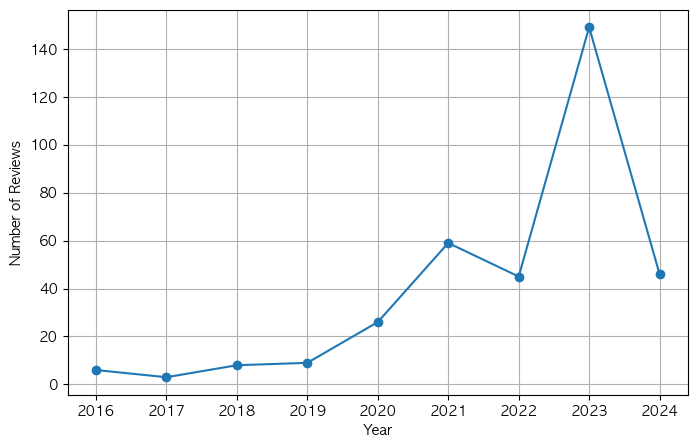

In [64]:
# 연도별 후기 작성개수를 방문횟수로 직결시킬 수는 없지만 상관관계가 있다고 가정해봄.
# 2023년도에 후기 작성개수 가장 많음. 2024년은 아직 다 지나지 않았지만 2020-2022년도와 비슷한 수준.
# 인기가 떨어지고 있는 곳은 아님을 추정할 수 있음.
spots = '광안리해수욕장'
year_cnt_df = pd.DataFrame(광안리해수욕장.Year.value_counts().sort_index())
plt.figure(figsize=(8, 5))
plt.plot(year_cnt_df.index, year_cnt_df ['count'], marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
# plt.title('Number of Reviews by Year')
plt.grid(True)
plt.savefig(f'data/img/{spots} numreview.png', bbox_inches='tight')
plt.show()

In [67]:
# 어느 월에 많이 가는가
# 역시 여름철에 방문 빈도가 높음
popular_month = pd.DataFrame(광안리해수욕장.Month.value_counts().sort_index())
popular_month['month'] = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
popular_month

,count,month
Month,,
01,23,Jan
02,17,Feb
03,31,March
04,21,April
05,43,May
06,34,June
07,29,July
08,47,Aug
09,21,Sep


In [ ]:
광안리해수욕장 = pd.read_csv('data/부산/광안리해수욕장.csv')
popular_month = pd.DataFrame(광안리해수욕장.Month.value_counts().sort_index())
popular_month['month'] = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.figure(figsize=(8, 8))
explode = [0] * len(popular_month)
explode[popular_month['count'].argmax()] = 0.1  # 첫 번째 조각을 약간 벗어나게 함
plt.pie(popular_month['count'], startangle=90, radius=0.8, labels=popular_month.month,
      autopct='%.1f%%',explode=explode)
plt.show()

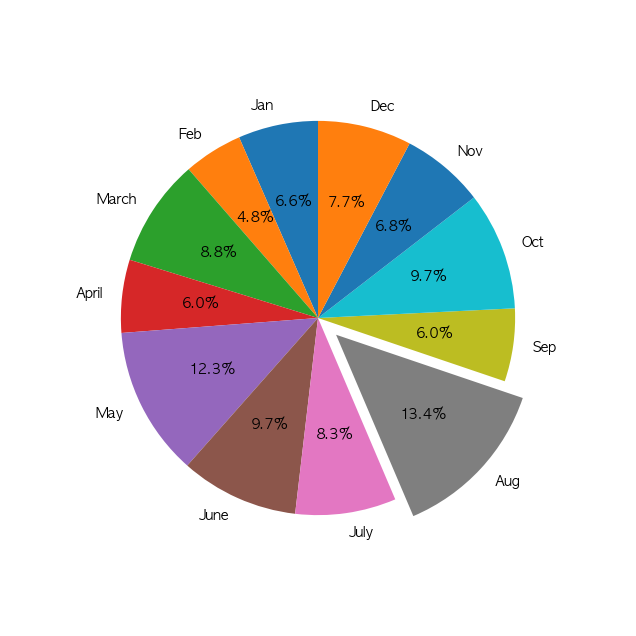

In [68]:
# popular_month = popular_month.sort_values(by='count', ascending=False)
spots = '광안리해수욕장'
# pie 차트 그리기
plt.figure(figsize=(8, 8))
# explode 설정 (0으로 초기화)
explode = [0] * len(popular_month)

# 가장 큰 값에 대한 explode 조정
explode[popular_month['count'].argmax()] = 0.1  # 첫 번째 조각을 약간 벗어나게 함
plt.pie(popular_month['count'], startangle=90, radius=0.8, labels=popular_month.month,
      autopct='%.1f%%',explode=explode)
# plt.title('월별 후기작성횟수 비율')
plt.savefig(f'data/img/{spots} pie.png', bbox_inches='tight')
plt.show()

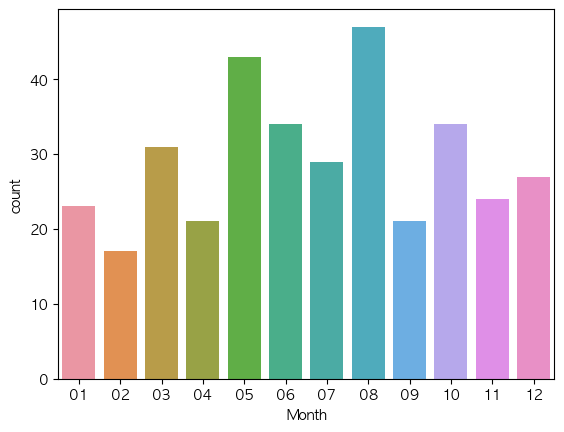

In [57]:
sns.barplot(data=popular_month, x=popular_month.index, y='count')
plt.show()

In [59]:
# 연도별 평점평균
year_rate = 광안리해수욕장.groupby('Year')['Rate'].mean()
year_rate.sort_values(ascending=False)

Year
2024    4.389130
2023    4.351007
2019    4.233333
2022    4.195556
2020    4.157692
2021    4.088136
2018    3.687500
2016    3.516667
2017    3.200000
Name: Rate, dtype: float64

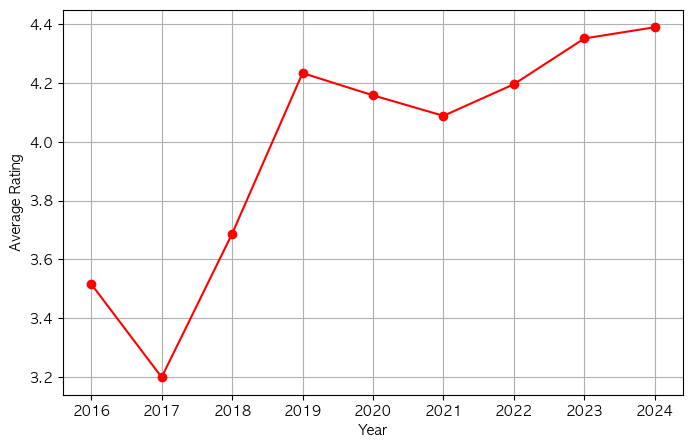

In [69]:
spots = '광안리해수욕장'
plt.figure(figsize=(8, 5))
year_rate.plot(kind='line', marker='o', color='r')
# plt.title('Average Rating by Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid(True)
plt.savefig(f'data/img/{spots} AvgRating.png', bbox_inches='tight')
plt.show()

In [28]:
# 후기 텍스트
# 이모지가 있을 경우 이모지 제외하고 나머지만 추출하기

def txt_without_emoji(df):
    contents = list(df['Review'])
    contents =  ' '.join(str(item) for item in contents)
    contents = re.sub(r'\bnan\b', '',contents)
    cleaned_text = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9\s]', '', contents)
    return cleaned_text

In [29]:
안목해변_후기 = txt_without_emoji(안목해변)

In [30]:
sw = pd.read_csv('데이터/한국어_불용어_목록.csv')

In [31]:
# 전체 후기 텍스트의 키워드 뽑기
def top_words(texts, spot):
    okt=Okt()
    nouns = okt.nouns(texts)
    nouns2 = [word for word in nouns if len(word) > 1]
    kor_sw = list(np.hstack(sw.values))
    nouns3 = [noun for noun in nouns2 if noun not in kor_sw]
    nouns_cnt = Counter(nouns3)
    tokens_df = pd.DataFrame(pd.Series(nouns_cnt), columns=['Freq'])
    sorted_df = tokens_df.sort_values(by='Freq',ascending=False)
    top_df = sorted_df.iloc[:20]
    sns.barplot(data = top_df, x='Freq', y= top_df.index)
    plt.title(f'{spot} 상위20개 단어빈도')
    plt.show()

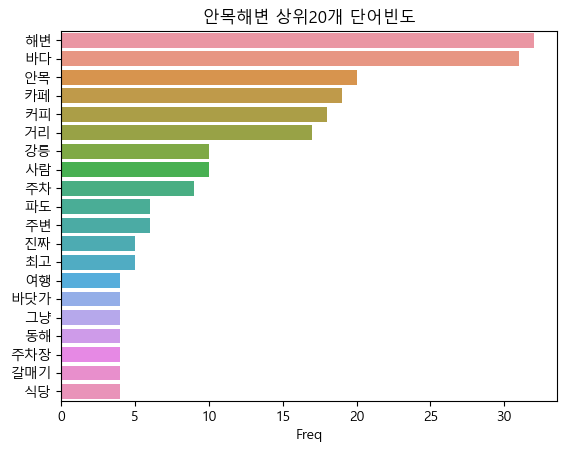

In [32]:
# 후기보다는 블로그 텍스트에서 뽑은 것이 양적으로 신뢰도가 높다고 생각
# 후기 텍스트는 아무래도 짧은 문장, 단어 수준이기 때문에 줄글의 블로그에서 다양한 키워드를 얻을 수 있다고 생각
# 블로그텍스트에서 뽑은 워드클라우드로 대체가능
top_words(안목해변_후기, '안목해변')

In [33]:
# 후기 텍스트는 블로그에 비해 상대적으로 길이가 짧으니까 형용사만 뽑아보자.
def adj(texts, spot):
    okt=Okt()
    adjectives = [word for word, pos in okt.pos(texts) if pos == 'Adjective']
    adj_cnt = Counter(adjectives)
    tokens_df = pd.DataFrame(pd.Series(adj_cnt), columns=['Freq'])
    sorted_df = tokens_df.sort_values(by='Freq',ascending=False)
    top_df = sorted_df.iloc[:20]
    sns.barplot(data = top_df, x='Freq', y= top_df.index)
    plt.title(f'{spot} 상위20개 형용사')
    plt.show()

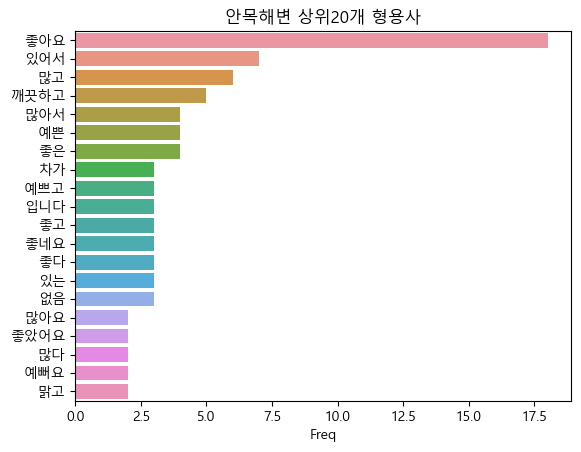

In [34]:
adj(안목해변_후기, '안목해변')

In [35]:
# 영어 텍스트 후기만 따로 뽑기
# 외국인 리뷰가 있을 경우, 다른 외국인들의 후기는 이랬어요~ 원문 그대로 보여주기
def eng_txt(df):
    all_contents = list(df['Review'])
    all_contents =  ' '.join(str(item) for item in all_contents)
    all_contents = re.sub(r'\bnan\b', '', all_contents)
    english_text = re.sub('[^a-zA-Z\s]', '',all_contents)
    english_text = re.sub(r'\n', '', english_text)
    return english_text
eng_txt(안목해변)

'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ktx                                                                                                                                                                                                                                                                                                                                                                                                                                                                  m m               

In [36]:
# 한글 텍스트 후기만 따로 뽑기
def kor_txt(df):
    all_contents = list(df['Review'])
    all_contents =  ' '.join(str(item) for item in all_contents)
    all_contents = re.sub(r'\bnan\b', '', all_contents)
    hangul_text = re.sub(r'[^가-힣\s]', '', all_contents)
    hangul_text = re.sub(r'\n', '', hangul_text)
    return hangul_text
한글_후기 = kor_txt(안목해변)

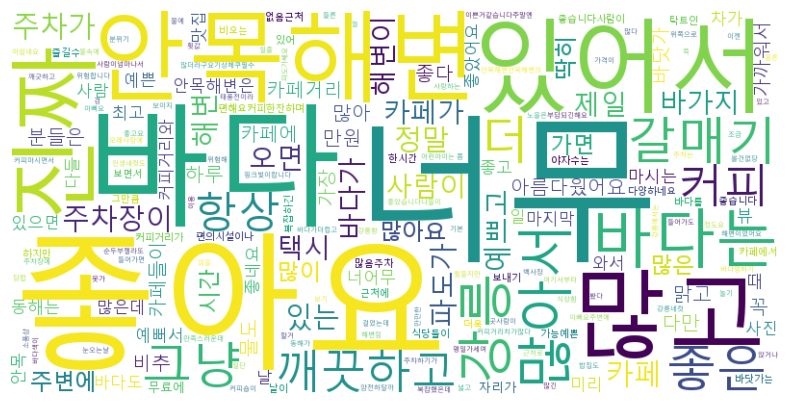

In [56]:
font_path = 'C:/Windows/Fonts/malgun.ttf'
wordcloud = WordCloud(width=800, height=400, background_color='white',font_path = font_path ).generate(한글_후기)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### 남이섬

In [120]:
남이섬 = pd.read_csv('후기별점/강원/남이섬.csv')
남이섬.drop(columns='Unnamed: 0', inplace=True)

In [121]:
남이섬['Spot']='남이섬'
남이섬['Region'] = '강원'
남이섬.columns = ['Rate', 'Date', 'Review', 'Spot', 'Region']
남이섬[['Year', 'Month', 'Day']] = 남이섬['Date'].str.rstrip('.').str.split('.', expand=True)
남이섬.head()

,Rate,Date,Review,Spot,Region,Year,Month,Day
0,4.4,2024.04.22.,NaN,남이섬,강원,2024,04,22
1,2.6,2024.04.18.,변화가 엄는곳 이네요,남이섬,강원,2024,04,18
2,3.5,2024.04.17.,"If you’re a nature person, this place would de...",남이섬,강원,2024,04,17
3,3.9,2024.04.14.,토ㅅ에 입장권 떴길래 찾아보실까봐^^\n친일파섬이예요,남이섬,강원,2024,04,14
4,2.6,2024.04.13.,걷기좋은 산책로,남이섬,강원,2024,04,13


In [122]:
남이섬.Year.value_counts()

Year
2023    104
2022     51
2021     51
2020     40
2019     40
2024     21
2018     16
2017      7
2016      7
Name: count, dtype: int64

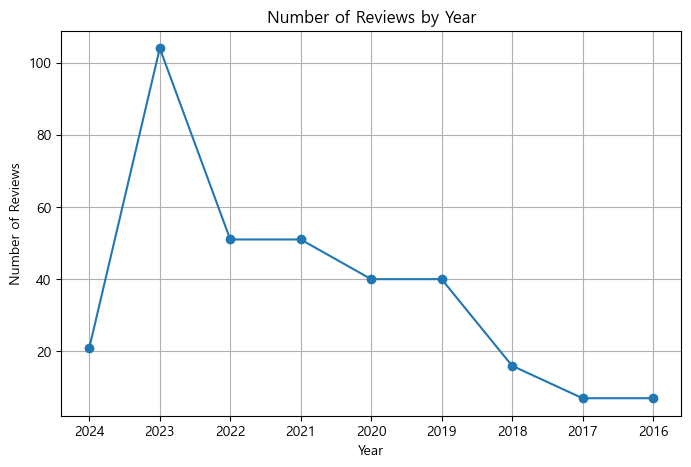

In [123]:
# 2023년도에 후기 작성개수 가장 많음. 

year_cnt_df = pd.DataFrame(남이섬.Year.value_counts(sort=False))
year_cnt_df 
plt.figure(figsize=(8, 5))
plt.plot(year_cnt_df.index, year_cnt_df ['count'], marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews by Year')
plt.grid(True)
plt.show()

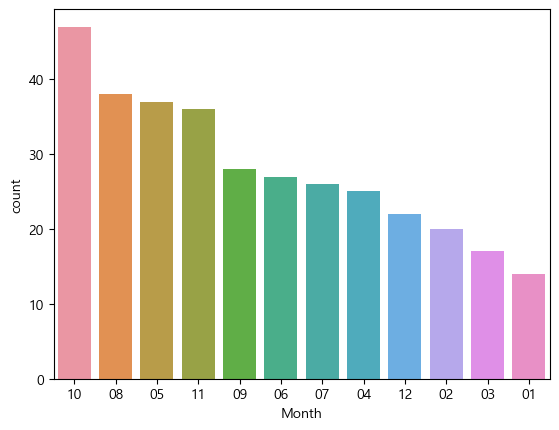

In [124]:
# 어느 월에 많이 가는가
# 10월달에 가장 많이 방문함
popular_month = pd.DataFrame(남이섬.Month.value_counts())
sns.barplot(data=popular_month, x=popular_month.index, y='count')
plt.show()

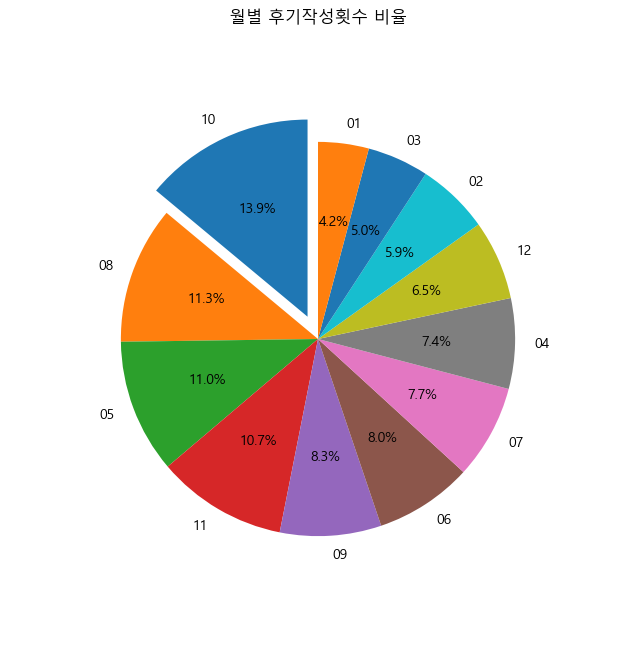

In [125]:
popular_month = popular_month.sort_values(by='count', ascending=False)

# pie 차트 그리기
plt.figure(figsize=(8, 8))
# explode 설정 (0으로 초기화)
explode = [0] * len(popular_month)
# 가장 큰 값에 대한 explode 조정
explode[0] = 0.1  # 첫 번째 조각을 약간 벗어나게 함
plt.pie(popular_month['count'], startangle=90, radius=0.8, labels=popular_month.index,
      autopct='%.1f%%',explode=explode)
plt.title('월별 후기작성횟수 비율')
plt.show()

In [126]:
# 연도별 평점평균
year_rate = 남이섬.groupby('Year')['Rate'].mean()
year_rate.sort_values(ascending=False)

Year
2024    4.014286
2023    3.972115
2017    3.742857
2021    3.690196
2018    3.606250
2016    3.571429
2022    3.533333
2020    3.520000
2019    3.282500
Name: Rate, dtype: float64

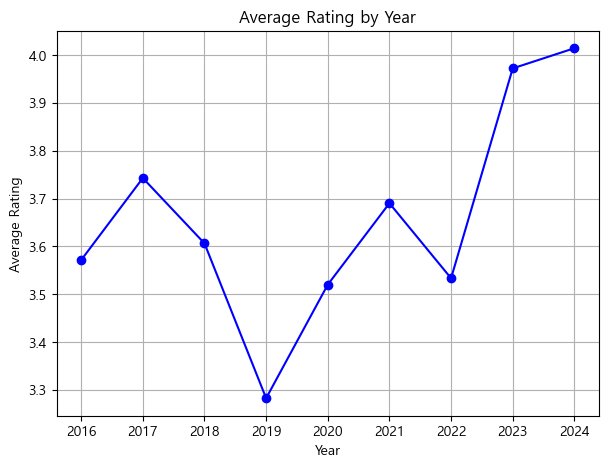

In [127]:
plt.figure(figsize=(7, 5))
year_rate.plot(kind='line', marker='o', color='b')
plt.title('Average Rating by Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

In [128]:
# 영어 텍스트 후기만 따로 뽑기
# 영어 후기는 양이 적으니까 그대로 제공해도 좋을 것 같음. 
def eng_txt(df):
    all_contents = list(df['Review'])
    all_contents =  ' '.join(str(item) for item in all_contents)
    all_contents = re.sub(r'\bnan\b', '', all_contents)
    english_text = re.sub('[^a-zA-Z\s]', '',all_contents)
    english_text = re.sub(r'\n', '', english_text)
    return english_text
eng_txt(남이섬)

'    If youre a nature person this place would definitely fit you You can find serenity in this place although it is a typical tourist place                                                                                                                                                                                                      The place is like magic to me I highly recommend you to visit it             I really loved coming here for the scenery Its a lovely place to enjoy the transitional seasons as the leaves turn different colors  there are several different places to enjoy on this island many restaurants gift shops camping and wildlife as well There are many rabbits and squirrels on this island and I watched as tourists and their small children chased them around with their dogs It may be a cultural difference and because I have two rabbits at home but I was very disturbed to see how little people cared for the safety of wildlife It would be nice for Nami to show some conce

In [129]:
남이섬_후기 = txt_without_emoji(남이섬)

In [130]:
남이섬_후기

' 변화가 엄는곳 이네요 If youre a nature person this place would definitely fit you You can find serenity in this place although it is a typical tourist place 토ㅅ에 입장권 떴길래 찾아보실까봐\n친일파섬이예요 걷기좋은 산책로   한번쯤 은 가볼만해요 그냥 산책정도만 하는거로 별로 볼껀없음 위에 자라섬이 더 괜찮은듯 민영휘파묘 가족들에게 미안해서 고개를 들 수 없습니다 \n4인 아뜰리에 별장에서 하루 보냈는데 이불은 3채가 준비 되어 있더라구요 아이들은 가로로 재웠습니다 정원재에서 메뉴를 보고 뷔페를 시켰더니 메뉴를 잘못 표기했고 불가하답니다 조식으로 황태해장국을 시켰는데 다른 상에 이미 나가서 다른 사람이 손 댄 것을 가져다 주더라구요 항의 하니깐 그제서야 죄송하답니다 캐리어가 두 개 있어서 선착장까지 데려다 달라고 했는데 30분을 기다려도 차가 안 오더니 바로 옆에 있던 빈 노란색 봉고차가 선착장에 나가더라구요 카운터에 물어보니 순서대로 처리하는 중이랍니다 덕분에 갯벌을 가로질러 수많은 외국인 인파를 뚫고 캐리어와 두 아이와 함께 돌아왔습니다 한 번 더 확인했으면 없었을 사소한 실수들이 쌓이고 쌓여 남이섬에 대한 좋은 추억을 모두 지워버렸습니다 감사합니다  남이섬을 남이섬의 나무들을  좋아하는 사람입니다 겨울 남이섬의 모습을 실제로 보고 싶어 계획만 여러차례 세웠는데  2월의 마지막주 언니동생과 남이섬을 다녀왔는데 가평에서부터 겨울왕국으로 변한 도로를 달려 도착해서 만난 눈덮힌 남이섬은 한 폭의 수묵화처럼 아름다웠습니다 섬 전체를 산책하듯이 걸으며 겨울정취를 오롯이 즐길 수 있어서 행복한 시간이었습니다 5월 푸르름이 짙어 갈 무렵  갈려고  합니다  드라마 겨울연가 촬영지이며\n남이 장군님의 전설이 살아 숨쉬는곳 엄마사랑해여   구경하기에 나쁘진 않아요 다만 눈 안오는날 가야할듯 바닥이 질척거림  The place is like magic to me 

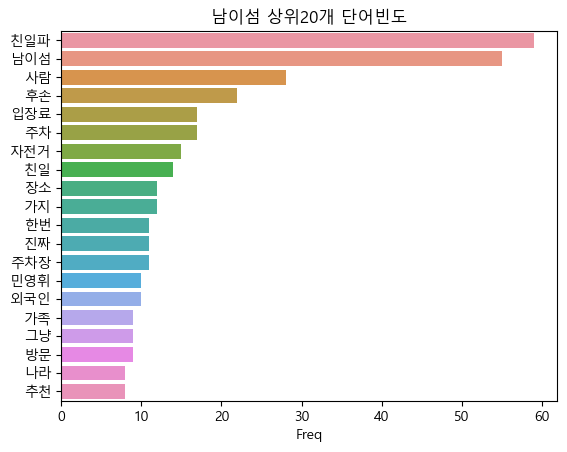

In [131]:
top_words(남이섬_후기, '남이섬')

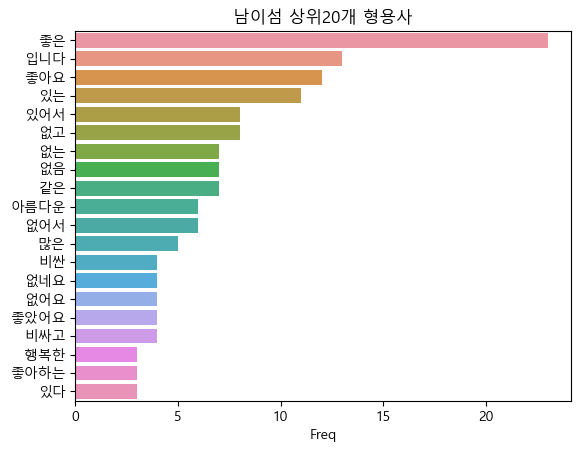

In [132]:
adj(남이섬_후기, '남이섬')

In [133]:
# 한글 텍스트 후기만 따로 뽑기
def kor_txt(df):
    all_contents = list(df['Review'])
    all_contents =  ' '.join(str(item) for item in all_contents)
    all_contents = re.sub(r'\bnan\b', '', all_contents)
    hangul_text = re.sub(r'[^가-힣\s]', '', all_contents)
    hangul_text = re.sub(r'\n', '', hangul_text)
    return hangul_text
한글_후기 = kor_txt(남이섬)

In [134]:
한글_후기

' 변화가 엄는곳 이네요                          토에 입장권 떴길래 찾아보실까봐친일파섬이예요 걷기좋은 산책로   한번쯤 은 가볼만해요 그냥 산책정도만 하는거로 별로 볼껀없음 위에 자라섬이 더 괜찮은듯 민영휘파묘 가족들에게 미안해서 고개를 들 수 없습니다 인 아뜰리에 별장에서 하루 보냈는데 이불은 채가 준비 되어 있더라구요 아이들은 가로로 재웠습니다 정원재에서 메뉴를 보고 뷔페를 시켰더니 메뉴를 잘못 표기했고 불가하답니다 조식으로 황태해장국을 시켰는데 다른 상에 이미 나가서 다른 사람이 손 댄 것을 가져다 주더라구요 항의 하니깐 그제서야 죄송하답니다 캐리어가 두 개 있어서 선착장까지 데려다 달라고 했는데 분을 기다려도 차가 안 오더니 바로 옆에 있던 빈 노란색 봉고차가 선착장에 나가더라구요 카운터에 물어보니 순서대로 처리하는 중이랍니다 덕분에 갯벌을 가로질러 수많은 외국인 인파를 뚫고 캐리어와 두 아이와 함께 돌아왔습니다 한 번 더 확인했으면 없었을 사소한 실수들이 쌓이고 쌓여 남이섬에 대한 좋은 추억을 모두 지워버렸습니다 감사합니다  남이섬을 남이섬의 나무들을  좋아하는 사람입니다 겨울 남이섬의 모습을 실제로 보고 싶어 계획만 여러차례 세웠는데  월의 마지막주 언니동생과 남이섬을 다녀왔는데 가평에서부터 겨울왕국으로 변한 도로를 달려 도착해서 만난 눈덮힌 남이섬은 한 폭의 수묵화처럼 아름다웠습니다 섬 전체를 산책하듯이 걸으며 겨울정취를 오롯이 즐길 수 있어서 행복한 시간이었습니다 월 푸르름이 짙어 갈 무렵  갈려고  합니다  드라마 겨울연가 촬영지이며남이 장군님의 전설이 살아 숨쉬는곳 엄마사랑해여   구경하기에 나쁘진 않아요 다만 눈 안오는날 가야할듯 바닥이 질척거림                   사진찍기 좋아유   많이 갔어도 또가고싶은곳 산책하기 좋아요                                                                                                        